### Plotting the number of pending cases 

#### How the data was preprocessed and analyzed?
- This was achieved by using the `date-of-filing` and `date-of-decision` columns
- A case is considered pending on a given date if the `date-of-filing` has passed but the `date-of-decision` has not been passed.
- The columns `date-of-filing` and `date-of-decision` were cleaned using the `Pandas.to_datetime()` method with the parameter `errors = coerce` to fill `NaT` in entries which were not in the correct `TimeStamp` format.
- The previous steps ensures that there are no faulty entries in either columns.
- A frequency map was created using `DataFrame[column].value_counts()`.
- Frequency of non occurent dates were filled with zeros using the `PandaSeries.reindex(range_of_dates, fill_value=0)` method.
- The graph is only shown for the given year, since, no cases filed after the given year are actually present in the `csv` file.

## Pending Cases plotter
- The number of cases received [TBX]

## Iterating through all cases csv files
- Since, each `cases_[year].csv` is massive (~1-2 gigabytes) we will use a diff subplot for each csv file
- Each plot image is stored in a `plot_img_list`

## Plotting number of cases filed on each day
- The `plot_img_list` obtained earlier can be iterated over and shown as subplots

# Insights on graphs obtained:
## Physical features of the graph
- The trend seems to violently oscillate.
- The amplitude of oscillation is increasing YoY.
- Weekends seem to be minimae getting only a fraction of cases on weekdays.
- Mondays and Wednesdays seem to be the maximae with Mondays receiving the highest number of cases on average.

## Implications of the physical features
- The density of cases filed are extremely high on weekdays, which suggests the direct
- The order of number of cases filed on peak days is of the order of 30000.
- The number of cases filed on peak days has steadily increased over the years.
- The period of 

# Hello! I'm Ujjwal Shekhar:)
I will be analyzing the database of ~80 million Indian district court data across states from the Development Data Lab.

The csv file has been downloaded from [the dropbox link](https://www.dropbox.com/sh/hkcde3z2l1h9mq1/AAB2U1dYf6pR7qij1tQ5y11Fa/csv?dl=0&subfolder_nav_tracking=1).

The metadata can be found here:
- [Acts sections metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vTNxZtceqgzYlUogz-gJfMfqm-RygJZcqfZiFCQAsJYFG7BU1_ZT5aKTPrNODeDgRnoyZFBnjt2sghd/pubhtml)
- [All cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml)
- [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml)

The following project was done as a part of the recruitment task given by [Precog Research Lab](https://precog.iiit.ac.in/).

# Importing modules and libraries

In [1]:
# IMPORTING MODULES
import os
import random
import numpy as np 
import pandas as pd 
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib 
from sklearn.preprocessing import LabelEncoder
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
from plotly.offline import init_notebook_mode, iplot

from sklearn.model_selection import train_test_split

init_notebook_mode(connected=True)

# Context
![Shashi Tharoor gif](https://2.bp.blogspot.com/-6r5_T5XrC9Q/U6BLfMvIoLI/AAAAAAAABIc/kC5zGcduYCg/s1600/Waqt-ShashiKapoor.gif)
    
Ask any indian how they feel about the judicial system of their country, and they will come up with constant anecdotes of cases being stuck for years. The confidence that people have in our country's judicial system seems low, with as many as [4.7 crore cases](https://www.thehindu.com/news/national/indian-judiciary-pendency-data-courts-statistics-explain-judges-ramana-chief-justiceundertrials/article65378182.ece) pending.

We will look at a subset of cases (from 2010 to 2018) and look at judges' data and various other data provided to us. This will be a part of the **ANALYSIS** section of the recruitment task given.

Following this, we come up with a classification problem that will help with [TBX]. This will be a part of the **CLASSIFICATION** section.

```
NOTE: The markdown provided in this `.ipynb notebook` will also be clubbed together in the README.MD file in the Github Repository associated with the notebook.
```

# Setting path variables 
We will setup global path variables for easy access and uniformity throughout the notebook.

**_NOTE_**:
- Since each `cases_{year}.csv` file is very large, we will store the path to the `cases` folder instead.
- Similar reasons for the `/keys/` folder. 

In [2]:
JUDICIAL_DATA_CSV_FOLDER_PATH = "/kaggle/input/precog-recruitment-task-csv/"

ACTS_SECTIONS_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "acts_sections/acts_sections.csv"
                    )

CASES_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "cases/cases/"
                    )

JUDGES_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH,
                        "judges_clean/judges_clean.csv"
                    )
KEYS_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "keys/keys/"
                    )
print( f"""
    Judges CSV file path : {JUDGES_CSV}
    Cases CSV folder path : {CASES_CSV_FOLDER}
    Acts Sections CSV file path: {ACTS_SECTIONS_CSV}
    Keys CSV file path: {KEYS_CSV_FOLDER}
""")


    Judges CSV file path : /kaggle/input/precog-recruitment-task-csv/judges_clean/judges_clean.csv
    Cases CSV folder path : /kaggle/input/precog-recruitment-task-csv/cases/cases/
    Acts Sections CSV file path: /kaggle/input/precog-recruitment-task-csv/acts_sections/acts_sections.csv
    Keys CSV file path: /kaggle/input/precog-recruitment-task-csv/keys/keys/



# Pre-processing and analyzing data 
We will try analyzing the datasets we have. But before we analyze the data itself, we must get comfortable with the database and how it is structured and ensure that the data types are appropriate.
Following this we will look at many exploratory features of the data provided, this will be done for every file and at a later point, the preprocessing part will be standardised as a function for future use.


## Judges data
The [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml) file gives us the following information, 

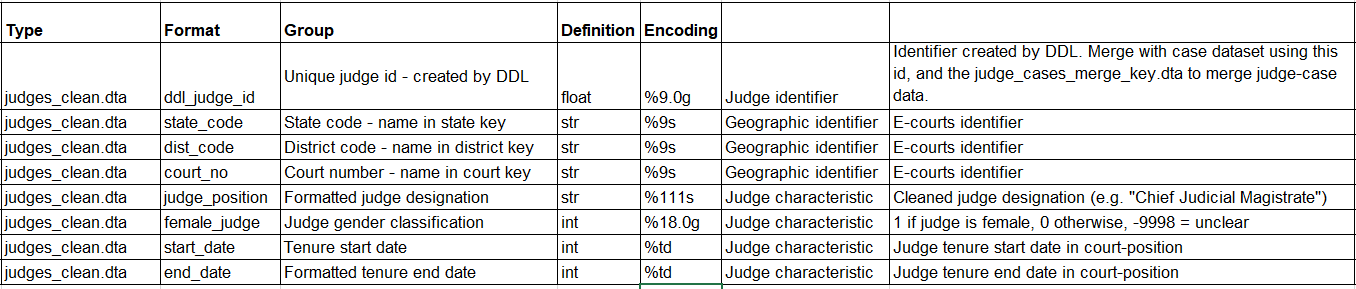

In [ ]:
df = pd.read_csv(JUDGES_CSV)
df.head()

Let's check whether or not the data type of each column is correct.

In [ ]:
df.dtypes

We can see that the `object` datatypes will actually be of the following types
- **judge_position** : `string`
- **female_judge** : [TBX]
- **start_date** and **end_date** : `Pandas.DateTime`

We will correct these dataypes first

In [ ]:
object_columns = df.select_dtypes(include = "object").columns
df[object_columns] = df[object_columns].astype("string")
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.date
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.date

df.dtypes

### Changing columns labels and replacing less readable values
On referring the DDL provided metadata (shown above), we realize that the following encoding was used in the `female_judge` column.

- 0 : male
- 1 : female
- -9998 : unclear

In [ ]:
df['female_judge'] = df['female_judge'].replace(
                ['0 nonfemale', '1 female', '-9998 unclear'],
                ['Male', 'Female', 'Unclear/Others']
            )
df = df.rename({'female_judge': 'gender'}, axis=1)
df['gender'] = df['gender'].astype("string")
df['gender'].head()

Since there is no numerical data to be analyzed, we will not use the `df.describe()` method here.

### Correlation matrix using Plotly.Express
We will use the correlation matrix to ensure that there are no columns with high correlation

**_NOTE:_** The corresponding correlation value has been shown as a colour, please refer to the color beside the correlation matrix image.

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

In [ ]:
le = LabelEncoder()
df['judge_position'] = le.fit_transform(df['judge_position']) 
df['gender'] = le.fit_transform(df['gender'])
df['start_date'] = le.fit_transform(df['start_date'])
df['end_date'] = le.fit_transform(df['end_date'])

px.imshow(df.corr(),title="Correlation Plot of Judges' database")

- We can see that `ddl_judge_id` and `state_code` are highly positively correlated, with a correlation value of ~$0.97$, this might be happening since 
- We can also see that `start_date` and `end_date` are also highly positively correlated, which also makes sense since `start_date` and`end_date` are constrained.
- `court_no` and `judge_position` are also quite correlated with ~$0.27$. A possible explanation might be that The Supreme Court will have a greater density of higher ranked judges. Although we might investigate this further.
- `end_date` also has a correlation ~$0.19$ with `dist_code` and `state_code`. 
<br>

## Making a preprocessing function for Judges' csv file.

In [ ]:
def get_preprocessed_judges():
    df = pd.read_csv(JUDGES_CSV)
    object_columns = df.select_dtypes(include = "object").columns
    df[object_columns] = df[object_columns].astype("string")
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.date
    df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.date
    df['female_judge'] = df['female_judge'].replace(
                                            ['0 nonfemale', '1 female', '-9998 unclear'],
                                            ['Male', 'Female', 'Unclear/Others']
                                        )
    df = df.rename({'female_judge': 'gender'}, axis=1)
    df['gender'] = df['gender'].astype("string")
    df = df.dropna()
    
    df.dtypes
    return df

df = get_preprocessed_judges()


### Overall gender demographic across judges

In [ ]:
num_genders = df['gender'].value_counts()
num_genders.head()

fig = num_genders.plot.bar(x='lab', y='val', rot=0, title="Overall gender demographic across judges")

The ratio of male judges to female is approximately $2:1 :: Male : Female$

In [ ]:
df['court_no'].nunique()

In [ ]:
fig=px.histogram(df, 
                 x="judge_position",
                 color="gender",
                 hover_data=df.columns,
                 title="Judge demographic in different powers",
                 barmode="stack",
                 )\
      .update_xaxes(categoryorder="total descending")
fig.show()

Using the above histogram plot, we can see that majority of the judges are:

- Chief judicial magistrate
- Civil judge senior division
- Civil judge junior division
- Civil court
- Judicial magistrate court
- Additional Chief judicial magistrate
- City civil and sessions court
- Additional district and sessions court
- Family court
- Principal district and sessions court
- Principal civil judge; etc,.

We also observe that there are more male judges than female judges


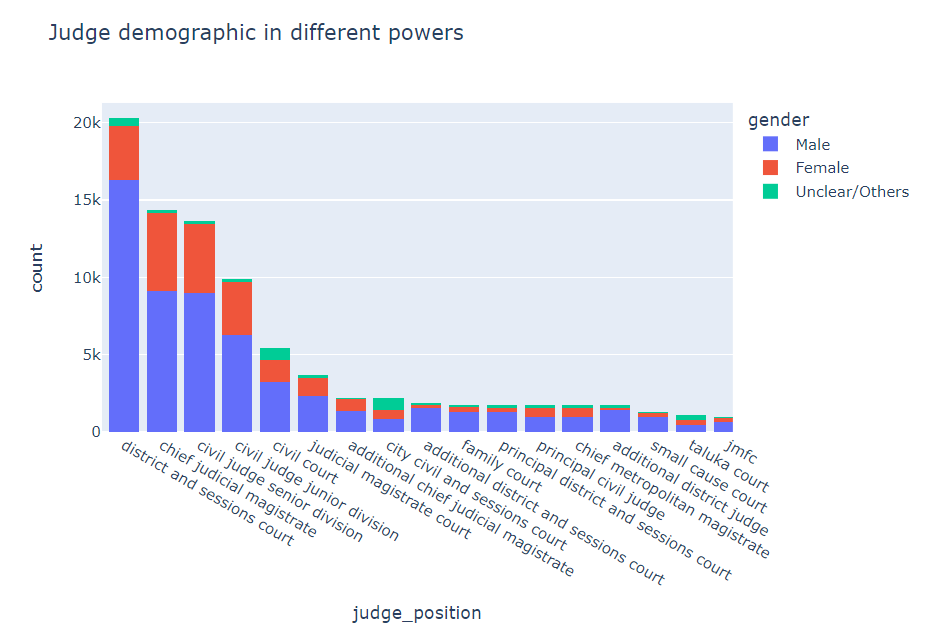

### Judges' gender demographic in different states

In [ ]:
state_vs_judges = df.groupby(['state_code', 'gender'])['state_code'].value_counts().to_frame()
state_vs_judges.columns = ['count']
state_vs_judges = state_vs_judges.droplevel(2)
state_vs_judges = state_vs_judges.reset_index()

state_vs_judges.head()

In [ ]:
df.head()

In [ ]:
fig=px.bar(state_vs_judges[state_vs_judges['gender'] != 'Unclear/Others'], 
                 x="state_code",
                 y="count",
                 color="gender",
                 hover_data=state_vs_judges.columns,
                 title="Judge gender demographic in different states",
                 barmode="stack",
                 )
fig.show()

We can see that the state with `state_code` = 1 has the highest total number of judges (~$22000$)

**_NOTE:_** The states have been anonimized using state codes.


We seem to have hit a roadblock, the judges csv seemingly gives no other insight.

### Trying to get hints for further analysis

Let's check if `end_date` has `NaN` values, so we can get the difference between them to get `total_days` they have worked for.

In [ ]:
df.isnull().sum()

Turns out that the `end_date` column DOES NOT have `Nan` values, if it did, we would replace the `NaN` values to a date that can't logically be valid (like `01-01-2222`). Then we can simply get rid of all entries in the`total_days` column that can't be physically possible. 

### Creating the total days column

In [ ]:
df['total_days'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'D')
df

### Making a temporary dataframe
We make a temporary dataframe and select only the entries with`judge_position` entries occuring more than $2000$ times  

In [ ]:
sub_df = df.filter(['judge_position','total_days', 'gender', 'state_code', 'dist_code'], axis=1)\
        [df.groupby('judge_position').judge_position.transform('count')>2000].copy()

sub_df

### Finding distribution of `judge_position` along different `state_code`

In [ ]:
# sub_df[sub_df['gender'] != 'Unclear/Others'].plot.bar(x="judge_position", y="state_code")

### Finding distribution of `judge_position` in different `dist_code`

In [ ]:
px.box(sub_df, x="judge_position", y="dist_code", color="gender")

### Violin plot to get insights on the data obtained

In [ ]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(
       x='total_days', 
       y='judge_position', 
       data=sub_df, 
       hue='gender', 
       ax=ax,
       title = "Judge_position in total days worked for",
    )
fig, ax = None = None, None

### Checking for skewness of features

In [ ]:
sub_df = df.filter(['total_days', 'gender'], axis=1)

plt.figure(figsize=(15,10))
for i,col in enumerate(sub_df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()
    
sub_df = None
df = None

## Acts Section data
The [Acts Sections metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vTNxZtceqgzYlUogz-gJfMfqm-RygJZcqfZiFCQAsJYFG7BU1_ZT5aKTPrNODeDgRnoyZFBnjt2sghd/pubhtml) file gives us the following information.

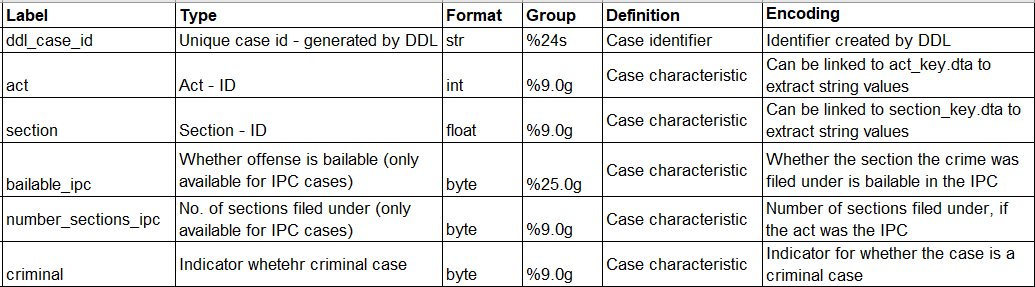

In [3]:
df_acts_sections = pd.read_csv(ACTS_SECTIONS_CSV, dtype='unicode', usecols=['ddl_case_id', 'act', 'section', 'criminal'])
df_acts_sections.head()

,ddl_case_id,act,section,criminal
0,06-03-02-210100004042014,17353,NaN,1
1,23-34-01-229900001012019,4759,NaN,1
2,13-18-03-204000030972016,17353,NaN,1
3,23-28-01-220102000232016,4759,NaN,1
4,01-35-05-203007002652012,17353,NaN,1


In [4]:
df_acts_sections = df_acts_sections[df_acts_sections['act'].notna()]

In [5]:
df_acts_sections.isnull().sum()

ddl_case_id          0
act                  0
section        4834909
criminal             0
dtype: int64

Lets check the data types

In [6]:
df_acts_sections.dtypes

ddl_case_id    object
act            object
section        object
criminal       object
dtype: object

Since we had force`dtype=unicode` all columns now have `dtype` set as an `object`.

### Changing column labels and dtypes of columns

In [7]:
df_acts_sections['ddl_case_id'] = df_acts_sections['ddl_case_id'].astype('string')
df_acts_sections['criminal'] = df_acts_sections['criminal'].astype('int64')
df_acts_sections['act'] = df_acts_sections['act'].astype('int64')
# df_acts_sections['section'] = df_acts_sections['section'].astype('int64')

In [8]:
df_acts_sections.dtypes

ddl_case_id    string
act             int64
section        object
criminal        int64
dtype: object

### Getting the number of criminals

`fig = px.histogram(df, x="criminal")` <br>
**WARNING** : Do not run the code, it might crash your laptop!!

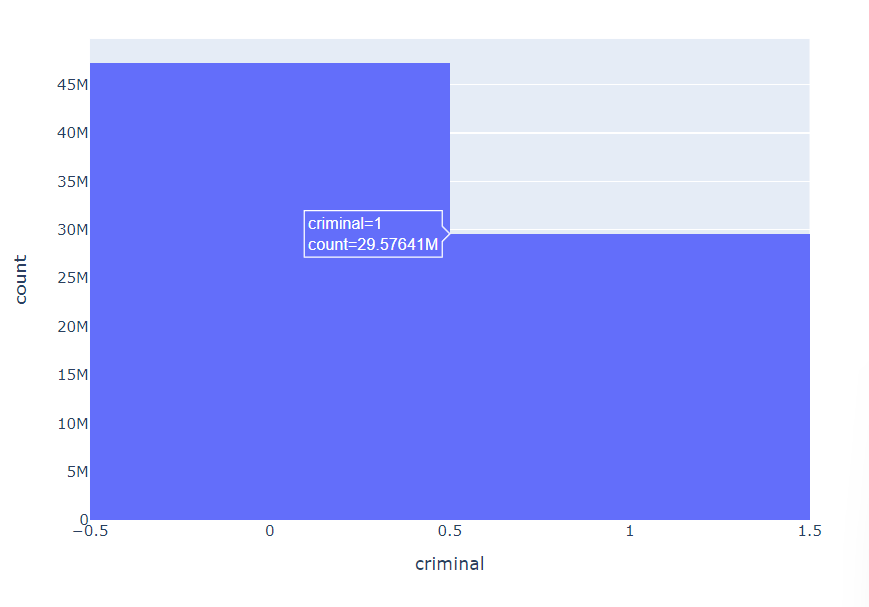

In [ ]:
plt.hist(df_acts_sections['criminal'])

## Cases csv 
The [Cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml#) file gives us the following information,

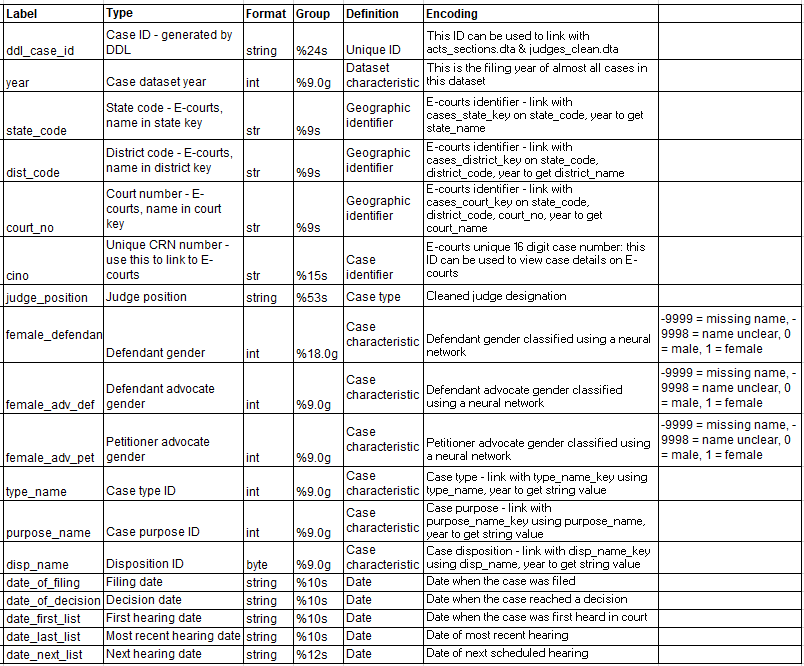

**NOTES:** 
- Since, each `case_{year}.csv` file is huge (~2GB each) we cannot handle more than one data frame at once.
- To be able to obtain insights for every year, we must make functions to handle a single data frame like before, except we can use a for-loop to call these functions for each `case_{year}.csv`.

Let's first make a list of years for easy reproducibility and readibility.

In [ ]:
year_list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### Exploring a sample csv
We will explore one case file and then make functions after every few steps so we can do the same for all `csv` files in the `CASES_CSV_FOLDER`.

**NOTE**: We will study the `cases_2014.csv` file, this csv has been selected since it is the median of `year_list` (No particular reason!)

In [ ]:
df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))
df.head

Let's check for the dtypes, we can use the data obtained from the [Cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml#) file to then convert `object` dtypes to their corresponding valid dtypes.

In [ ]:
df.dtypes

There are a lot of columns that have to be converted into a non-object dtype!
We will convert them into their intended dtypes.

### Stringify columns

In [9]:
## Changing column datatypes to strings where needed
def convert_str_dtype(df, column_name):
    df[column_name] = df[column_name].astype("string")
    return df

def str_dtypes_preprocess(df, column_list):
    for column_name in column_list:
        df  = convert_str_dtype(df, column_name)
        
    return df

str_column_list=[
    'ddl_case_id',
    'state_code',
    'dist_code',
    'court_no',
    'judge_position'
]

In [ ]:
df = str_dtypes_preprocess(df, str_column_list)
df.head(10)

### Cleaning `gender` columns
The column labels and entries are not easy read, we seek to standardize the columns.

In [10]:
## Renaming and replacing values in `female_{X}` column
def fix_gender_dtype1(df, column_name):
    new_column_name = column_name.split('_')[1] + "_gender"

    df[column_name] = df[column_name].replace(
        ['0 nonfemale', '0 male','1 female', '-9998 unclear', '-9999 missing name'],
        ['Male', 'Male', 'Female', 'Unclear/Others', 'Missing']
    )

    df = df.rename({column_name: new_column_name}, axis=1)
    df[new_column_name] = df[new_column_name].astype("string")
    
    return df

## Renaming and replacing values in `female_{X]_{Y}` column
def fix_gender_dtype2(df, column_name):
    new_column_name = column_name.split('_')[1] + "_" + column_name.split('_')[2] + "_gender"
    df[column_name] = df[column_name].replace(
        [0, 1, -9998, -9999],
        ['Male', 'Female', 'Unclear/Others', 'Missing']
    )

    df = df.rename({column_name: new_column_name}, axis=1)
    df[new_column_name] = df[new_column_name].astype("string")
    
    return df
    
def gender_dtypes_preprocess(df):
    for column_name in ['female_defendant', 'female_petitioner']:
        df = fix_gender_dtype1(df, column_name)
        
    for column_name in ['female_adv_def', 'female_adv_pet']:
        df = fix_gender_dtype2(df, column_name)
        
    return df

In [ ]:
df = gender_dtypes_preprocess(df)
df.head(10)

### Clean date-time columns

In [11]:
## Making a standardised function to convert to datetime
def convert_date_time(df, column_name):
    df[column_name] = pd.to_datetime(
            df[column_name], errors='coerce'
        ).dt.date
    
    return df

## Fixing date datatypes 
def date_dtype_preprocess(df, column_list):
    for column_name in column_list:
        df = convert_date_time(df, column_name)
        
    return df

date_column_list = [
    'date_of_filing',
    'date_first_list',
    'date_last_list',
    'date_next_list'
]

In [ ]:
df = date_dtype_preprocess(df, date_column_list)
df.head(10)

In [ ]:
df.info()

We will drop all entries with any null value before studying the transforming strings by labelling them for correlation study

In [ ]:
df = df.dropna()

Now, that the data types have been fixed, and null values have been removed, lets plot the correlation matrix.

### Labelling columns to get a one-one mapping

In [ ]:
def label_columns(df, column_list : list):
    le = LabelEncoder()
    for column_name in column_list:
        df[column_name]=le.fit_transform(df[column_name])

column_list = [
    'ddl_case_id', 'state_code', 'dist_code',
    'court_no','cino', 'judge_position',
    'defendant_gender', 'petitioner_gender',
    'adv_def_gender', 'adv_pet_gender',
    'date_of_filing', 'date_first_list',
    'date_last_list', 'date_next_list'
]

label_columns(df, column_list)

df = df.drop(['year'], axis=1)

In [ ]:
df.head(10)

In [ ]:
px.imshow(df.corr(),title="Correlation Plot of Judges' database", text_auto=True)

- `date_next_list` and `date_last_list` are extremely correlated, we suspect that this is because the last time the `next` date was the `last` date filled.
- `date_first_list` is also positively correlated with `date_next_list` and `date_last_list`. This might be happening since 
- `date_first_list` and `date_of_filing` are also decently correlated, that might be because 
- A bunch of pairs of genders (e.g.: `adv_pet_gender` and `pertitioner_gender`) also have a correlation value of >$0.25$ 

### Defining a function to preprocess cases_csv file

#### Converting a `state_code` to it's string values using the `cases_state_key.csv` file

In [12]:
def state_name_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_state_key.csv"),
                                usecols = ['year','state_code', 'state_name'])
    df_merge['state_code'] = df_merge['state_code'].astype('string')
    df = df.merge(df_merge, on=['year', 'state_code'])
    return df

#### Converting a `purpose_name` to their it's string value using the `purpose_name_key.csv` file

In [13]:
def purpose_name_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "purpose_name_key.csv"),
                              usecols=['year', 'purpose_name', 'purpose_name_s'])
    df = df.merge(df_merge, on=['year', 'purpose_name'])
    return df

#### Converting a `disp_name` to it's string value using the `disp_name_key.csv` file

In [14]:
def disp_name_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "disp_name_key.csv"),
                              usecols=['year', 'disp_name', 'disp_name_s'])
    df = df.merge(df_merge, on=['year', 'disp_name'])
    return df

#### Converting a `type_name` to it's string value using the `type_name_key.csv` file

In [15]:
def type_name_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "type_name_key.csv"),
                              usecols=['year', 'type_name', 'type_name_s'])
    df = df.merge(df_merge, on=['year', 'type_name'])
    return df

#### Converting a `dist_code` to it's string value using `cases_district_key.csv` file

In [16]:
def dist_name_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_district_key.csv"),
                                usecols = ['state_code', 'dist_code', 'district_name'])
    df_merge['state_code'] = df_merge['state_code'].astype('string')
    df_merge['dist_code'] = df_merge['dist_code'].astype('string')
    df = df.merge(df_merge, on=['state_code', 'dist_code'])
    return df

#### Getting string values of `court` related columns using the `cases_court_key.csv` file

In [17]:
def case_court_convert(df):
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "cases_court_key.csv"),
                                usecols = ['year', 'state_code', 'dist_code', 'court_no', 'court_name'])
    df_merge['state_code'] = df_merge['state_code'].astype('string')
    df_merge['dist_code'] = df_merge['dist_code'].astype('string')
    df_merge['court_no'] = df_merge['court_no'].astype('string')
    df = df.merge(df_merge, on=['year', 'state_code', 'dist_code', 'court_no'])
    return df

### Merging the functions declared above into a function that can be used to return a cleaned version of case_csv 
- The `test_mode` parameter (<em> defaults to `False` </em>) can be set `True` to obtain the first 10000 rows of a `case_{year}.csv` file. This was added to speed up testing where all columns aren't needed/
- The `to_unlabel` parameter (<em> defaults to `False` </em>) can be set `True` to obtain the stringified version of the `case_{year}.csv` file. This was added to improve flexibilty.
- The `year` parameter is used to fetch the `case_{year}.csv` file of a particular year, it adds flexibility and is a more pythonic way of doing things.

In [18]:
def preprocessing_case_csv(year, test_mode=False, to_unlabel=False):
    
    ## If the function is called in test_mode, we will only take the top 10000 rows
    if not test_mode:
        df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"))
    else:
        df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"), nrows=10000)
   
    ## String-type column types are cleaned 
    df = str_dtypes_preprocess(df, str_column_list)
    
    ## Gender-related column types are cleaned
    df = gender_dtypes_preprocess(df)
    
    ## Date-related column types are cleaned
    df = date_dtype_preprocess(df, date_column_list)

    if to_unlabel:
        ### Joining states
        df = state_name_convert(df)
        
        ### Joining purpose names
        df = purpose_name_convert(df)
        
        ### Joining disposition names
        df = disp_name_convert(df)
        
        ### Joining type names
        df = type_name_convert(df)
        
        ### Joining districts
        df = dist_name_convert(df)
        
        ### Joining court names
        df = case_court_convert(df)
        
        ### Removing extraneous columns
        df = df.drop(columns=['cino', 
                              'state_code', 'dist_code', 
                              'court_no', 'purpose_name', 
                              'type_name', 'disp_name'])
    return df

### Number of cases filed each day

We must look at how the number of filed cases changes over different time frames.<br>
We run a loop to go through every year, and make a Series/Dataframe which can then be plotted. <br>

In [ ]:
# plot_list = []
# pending_cases_list = []

# fig, ax = plt.subplots(figsize=(21,6))


# for year in range(2010,2019):
#     df = preprocessing_case_csv(year)

#     freq_filed_cases = df['date_of_filing']\
#                             .value_counts()\
#                             .asfreq('D', fill_value=0)
    
#     df_filed_cases = freq_filed_cases\
#                             .to_frame()\
#                             .reset_index()\
#                             .rename(columns={'index' : 'date', 'date_of_filing': 'num_filed_cases'})
            
#     df_filed_cases['weekday'] = df_filed_cases['date'] \
#                                             .dt.day_name()

#     weekwise_filed_cases = df_filed_cases.weekday.value_counts()
    
#     ax.plot(df_filed_cases['date'], df_filed_cases['num_filed_cases'], label=str(year))
#     ax.set_xlim("01-01-2010", "01-01-2019")

In [ ]:
# fig = px.histogram(df, x="disp_name")

In [ ]:
# fig.show()

# Insight #1
## Analyzing criminal cases that get dismissed

A dismission is the disposition of a case when there isn't enough evidence for the case to continue, states with higher number of dismissed cases means that the judicial setup of that state is not competent enough and might suggest some form of corruption

## Stages in the insight gathering attempt:
- Firstly, we will explore how we will generate the insights and look at interesting visualization strategies, this part strongly resembles the EDA stage of our data analysis done before.
- Secondly, we will standardize the stuff that was done in the first step. The ideas explored will be made into functions and then we can run a loop and look at the time-variance of these insights YoY. 

## Stage #1


### Merging appropriate dataframes 

We will start off by loading `cases_{year}.csv` here, for testing purposes let's try this with `case_2014.csv`. Then, we will merge the`criminal` column from `acts_sections.csv`.

In [ ]:
df = preprocessing_case_csv(year=2014, to_unlabel=True)
df = df.merge(df_acts_sections, on=['ddl_case_id'])

df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                      usecols=['act', 'act_s'])
df = df.merge(df_merge, on='act')

df.head(10)

In [ ]:
df = df.drop(columns = ['date_of_decision'])
df = df.dropna()

### Checking how quickly each state responds to a criminal case being filed
We can check this by finding the number of days between `date_first_list` and `date_of_filing`.

In [ ]:
df['date_first_list'] = pd.to_datetime(
    df['date_first_list'], errors='coerce'
).dt.date
df["quickness_of_action"] = ((df.date_first_list - df.date_of_filing)/np.timedelta64(1, 'D')).astype(int)

### Filtering out non-criminal cases
We can filter out non-criminal cases by checking if the value in the `criminal` column of our df is $1$ or not.<br>
However, for readabiltiy, we will convert the column dtype to `bool` and then check if the corresponding value is `True`.

In [ ]:
df.criminal = df.criminal.astype('bool')
df.criminal.value_counts()

In [ ]:
df = df[(df.criminal == True)]

Let's also drop the `ddl_case_id` and `cino` columns since they are unique identifiers mostly useful for connecting tables. These values are not needed any more

In [ ]:
df = df.drop(columns=['ddl_case_id', 'act'])

In [ ]:
df.info()

### Making a Series/Dataframe by aggregating mean `quickness_of_action` by the `state_name` column.

This gives us the statewise time taken for a case to get its first hearing date from the day of filing.

In [ ]:
avg_quickness_states = df.groupby(['state_name'])['quickness_of_action'].mean()
avg_quickness_states.sort_values(ascending=False)
time_taken_states = avg_quickness_states.to_frame()
time_taken_states = time_taken_states.reset_index()
time_taken_states.head(10)

### Plotting obtained Dataframe

In [ ]:
px.line(time_taken_states, x='state_name', y='quickness_of_action', title="Amount of time (in days) taken by each state to hear a criminal case after filing")

A line plot won't help us in visualizing the data properly. A better way of visualizing data that is identified by a `Geographical identifier` is using `Choropleths`. These are heat maps with the heatness values representing the value and the location of the heatmap is a Geographical map, which, in our case is of India, split by states.

### Cleaning the `time_taken_states` dataframe we have obtained to plot a more quality choropleth 

In [ ]:
### The `properties.ST_NM` property of the GeoJSON file has a few names that are written differently in the `state_name` column of our dataframe.
### We will replace these names in the dataframe with the ones in the GeoJSON
time_taken_states = time_taken_states.replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )

### Moreover, in the GeoJSON `Ladakh` has a separate area, so we will fill it with the values in Jammu and Kashmir
val = time_taken_states[time_taken_states['state_name']=='Jammu & Kashmir'].values[0][1]
time_taken_states = time_taken_states.append({
    'state_name' : 'Ladakh',
    'quickness_of_action' : val
}, ignore_index=True)

### Plotting the choropleth using `px.choropleth`

In [ ]:
px.choropleth(
    time_taken_states,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='quickness_of_action',
    color_continuous_scale='Reds',
    fitbounds="locations"
)

## Insights from the state-wise analysis of data on 2014
- It looks like South India reacts quickly to criminal cases being filed.
- The Northern-Eastern part of India seems to be quite slow, especially **West Bengal** being the slowest pan India
- This seems to imply that a in states that even in a (relatively) quick-to-respond it usually takes around 3 weeks to hear the case.
- In states that are more lousy it takes around 8-10 months to process a criminal case.
- These legal practitioners to have a better estimate of when their clients might get their caes heard.
- Moreover, such insights can help the State and Central Governments to collect data on the Judicial system of a state as a whole.
- It can also help a State Government make amends to their judicial process and/or look at what other states have done to improve. 

We can now plot the `quickness_of_action` it districtwise.

In [ ]:
avg_quickness_district = df.groupby(['district_name'])['quickness_of_action'].mean()
avg_quickness_district = avg_quickness_district.to_frame()
avg_quickness_district = avg_quickness_district.reset_index()

# avg_quickness_district = avg_quickness_district[avg_quickness_district.quickness_of_action > 1000]
avg_quickness_district.head(10)

In [ ]:
px.choropleth(
    avg_quickness_district,
    geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
    featureidkey='properties.NAME_2',
    locations='district_name',
    color='quickness_of_action',
    fitbounds="locations",
    color_continuous_scale='Viridis',
    title='District-wise criminal case hearing wait time',
)

## Insights from the district-wise `quickness_of_action` study on cases in 2014
- It looks like most districts have an average value close to their state-mean.
- This implies that most courts in a state will follow what other courts in the state are doing.
- Since District Courts come under the High Court of the State, and so a sloppy State will have sloppy District Court proceedings in general, and a quick State will have a quick District Court.
- We can also notice that there are a few outliers like `West Khasi Hills` with an average of ~$1900$ days or 5-6 years!!
- However these outliers are very very sparse, and in most cases the cases will take around 3-5 weeks before being heard.
- If a district is even slightly noticable in the heatmap, it takes ~$1000$ days or a whopping 3 years to hear such a case.
- This plot can help identify the slowpokes in a state and the High Court of the corresponding state can then take a closer look at what's going on in that particular district.
- Moreover, this might also allow legal practioners to get a better estimate on how much time it will take before they will get a case heard, it will useful for them to have some idea.

```
NOTE : A few districts are shown as blank since there is a mismatch in MANY names between the district names in the GeoJSON file and the district names that are given in the file
```

Since the above visualizations will tell us all about the quickness of action in every state, we should also look at what are the most common dispositions in each state, and overall

### Making a frequency table of each disposition and cleaning it (like we did in the section before this) for the choropleth

In [ ]:
df.head()

In [ ]:
disp_freq_state_wise = (df.groupby(['year', 'disp_name_s'])['state_name'].value_counts()).to_frame()
disp_freq_state_wise.columns = ['count']
disp_freq_state_wise = disp_freq_state_wise.reset_index()
disp_freq_state_wise['state_name'] = disp_freq_state_wise['state_name'].replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )

val = disp_freq_state_wise[disp_freq_state_wise['state_name']=='Jammu & Kashmir'].values
for entry in val:
    disp_freq_state_wise = disp_freq_state_wise.append({
        'state_name' : 'Ladakh',
        'disp_name_s' : entry[1],
        'year' : entry[0],
        'count': entry[3]
    }, ignore_index=True)

disp_freq_state_wise.head(10)

We will add animation sliders to view every disposition state by state

In [ ]:
px.choropleth(
    disp_freq_state_wise,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='count',
    animation_frame='disp_name_s',
    fitbounds="locations",
    color_continuous_scale='YlOrRd',
    title='Statewise criminal dispositions'
)

## Insights from the disposition ratio in each state

### Analyzing district-wise to get clusters of dispositions across the map

In [ ]:
disp_freq_district_wise = (df.groupby(['year', 'disp_name_s'])['district_name'].value_counts()).to_frame()
disp_freq_district_wise.columns = ['count']
disp_freq_district_wise = disp_freq_district_wise.reset_index()

disp_freq_district_wise.head(10)

In [ ]:
px.choropleth(
    disp_freq_district_wise,
    geojson="https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson",
    featureidkey='properties.NAME_2',
    locations='district_name',
    color='count',
    animation_frame='disp_name_s',
    fitbounds="locations",
    color_continuous_scale='Viridis',
    title='District-wise criminal dispositions',
)

In [204]:
avg_quickness_states = None
avg_quickness_district = None
time_taken_states = None
disp_freq_district_wise = None

Since there are too many districts, it gets cumbersome to look at this data district by district, so we won't do it in the second stage of our insight

## Stage #2

### Standardizing everything as a function, and putting yearwise plots/series in lists that we will later access

In [197]:
glob_datas = []

colors_list = [
    "#808000",
    "#911eb4",
    "#9A6324",
    "#000000",
    "#000075",
    "#fabed4",
    "#aaffc3",
    "#dcbeff",
]

In [198]:
def clean_state_choropleth(choropleth_df):
    choropleth_df['state_name'] = choropleth_df['state_name'].replace(
                ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
                ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
            )

    val = choropleth_df[choropleth_df['state_name']=='Jammu & Kashmir']
    val['state_name'] = 'Ladakh'

    choropleth_df = choropleth_df.append(val, ignore_index=True).reset_index()

    return choropleth_df

In [199]:
def state_vs_time(df, year : int, col_to_aggr : str, col_to_plot : str, cols_to_group : list, method : str, glob_datas : list, line_plot_list=False, animation_column=None):
    ### Rate of response study of criminal cases
    if method == 'value_counts':
        choropleth_title = "Statewise Disposition frquency for Criminal Cases in the year " + str(year) 
        grouped_data = df.groupby(cols_to_group)[str(col_to_aggr)].value_counts()
    elif method == 'mean':
        choropleth_title = "Statewise Response Time to Criminal Cases in the year " + str(year)
        grouped_data = df.groupby(cols_to_group)[str(col_to_aggr)].mean()
    else:
        return 
    ### Save the series obtained
    framified_grouped_data = grouped_data.to_frame()
    grouped_data = None
    framified_grouped_data.columns = ['count']
    framified_grouped_data = framified_grouped_data.reset_index()

    ### Save the line plot
    if line_plot_list is True:
        data_to_add = px.line(framified_grouped_data, x='state_name', y='count').data
        data_to_add[0]['line']['color'] = colors_list[year - 2010]
        data_to_add[0]['name'] = str(year)

        if int(len(glob_data)) > 0:
            glob_datas[0] += data_to_add
        else:
            glob_datas.append(data_to_add)

        data_to_add = None
    
    plot_state_choropleth(clean_state_choropleth(framified_grouped_data), col_to_plot, animation_column, choropleth_title)
    framified_grouped_data = None

In [200]:
def plot_state_choropleth(choropleth_df, col_to_plot, animation_column=None, title=None):
    ### Plot the choropleth
    fig = px.choropleth(
        choropleth_df,
        geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        featureidkey='properties.ST_NM',
        locations='state_name',
        color=col_to_plot,
        animation_frame=animation_column,
        color_continuous_scale='Reds',
        fitbounds="locations",
        title=title
    )
    
    fig.show()
    
    fig = None

In [206]:
def preprocess_insight1_df(year):
    df = preprocessing_case_csv(year=year, to_unlabel=True)
    df = df.merge(df_acts_sections, on=['ddl_case_id'])
    
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                          usecols=['act', 'act_s'])
    df_merge = df_merge.dropna()
    df_merge['act'] = df_merge['act'].astype("int64")
    
    df = df.merge(df_merge, on='act')
    
    df_merge = None
    
    df = df.drop(columns = ['section', 'date_of_decision'])
    df = df.dropna()
    df['date_first_list'] = pd.to_datetime(
        df['date_first_list'], errors='coerce'
    ).dt.date
    df["quickness_of_action"] = ((df.date_first_list - df.date_of_filing)/np.timedelta64(1, 'D')).astype(int)

    df.criminal = df.criminal.astype('bool')
    
    df = df[(df.criminal == True)]
    df = df.drop(columns=['ddl_case_id', 'act'])
    
    return df

In [202]:
def insight_1(df, year : int):
    ### Make a dataframe of time taken between filing and hearing
    state_vs_time(df, year, 'quickness_of_action', 'count', ['state_name'], "mean", glob_datas, True, None)

    ### Statewise disposition choloropleth heat map
    state_vs_time(df, year, 'state_name', 'count', ['year', 'disp_name_s'], "value_counts", None, False, 'disp_name_s')

### Running a loop over all years

**NOTE:** This might take a while to run, since each case csv is massive and merging it with the huge 3gb acts_sections file is also painful

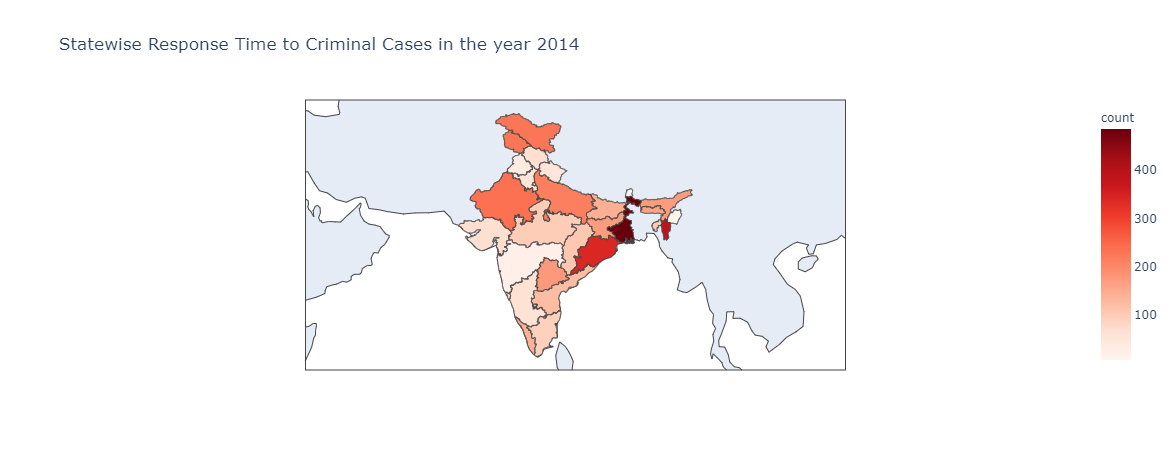

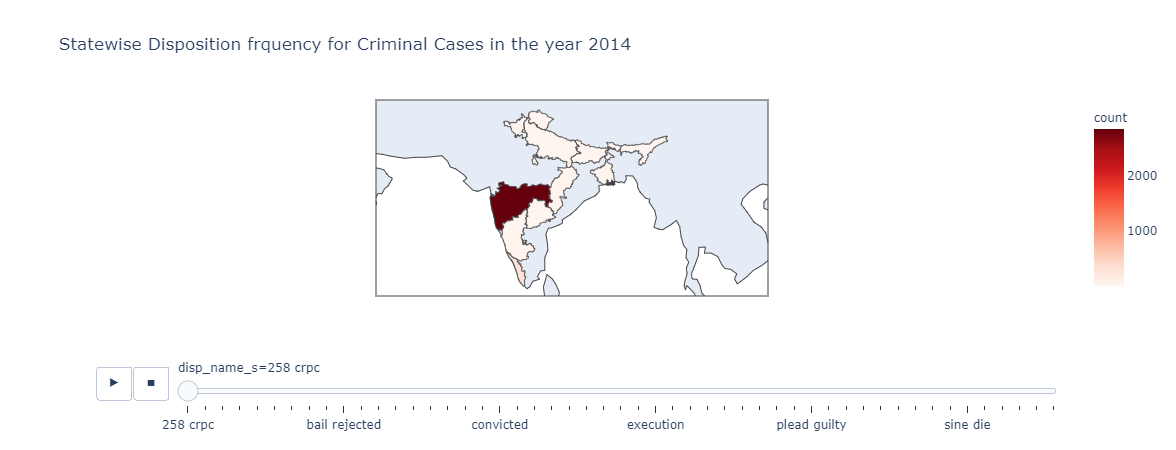

In [203]:
insight_1(df, 2014)

In [ ]:
for year in range(2010,2012):
    df = preprocess_insight1_df(year)
    insight_1(df)
go.Figure(data=glob_datas[0])

Making a `fig_net` figure by merging data all across the `quickness_line_plots` list that we have

In [ ]:
def plot_state_wise_choropleths(choropleth_list : list, non_sp_mode=False):
    
    if non_sp_mode:
        for i, f in enumerate(choropleth_list):
            f.data[0].name = 2010+i
            f.layout.coloraxis.colorbar.title.text = "Year "+str(2010+i)

            f.show()
        return
    
    years_list = [int(i) for i in range(2010,2012)]
    rows = 2
    cols = 1

    fig = sp.make_subplots(
        rows=rows, cols=cols,
        specs = [[{'type': 'choropleth'} for c in np.arange(cols)] for r in np.arange(rows)],
        subplot_titles = years_list)
 
    for i, f in enumerate(choropleth_list):
        fig.add_trace(f.data[0], row = i//cols+1, col = i%cols+1)
    fig.show()

## Insights obtained from analyzing state-wise time taken


# Insight #2
## Analyzing marriage related cases, religion-marriage case count, child marriage case count

### Preprocessing and replacing `int` labels with their names

In [208]:
df = preprocessing_case_csv(year=2014, to_unlabel=True)

In [209]:
df_acts_sections.isnull().sum()

ddl_case_id          0
act                  0
section        4834909
criminal             0
dtype: int64

### Merging with `acts_sections.csv` and replacing `act` with it's name

In [210]:
df = df.merge(df_acts_sections, on=['ddl_case_id'])
df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "act_key.csv"),
                      usecols=['act', 'act_s'])
df = df.merge(df_merge, on='act')

Dropping the `sections` and `date_of_decision` column since they have too many Null values

In [211]:
df = df.drop(columns = ['section'])
df = df.dropna()

In [212]:
df.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_first_list,date_last_list,date_next_list,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,criminal,act_s
0,01-01-01-201908000022014,2014,chief judicial magistrate,Unclear/Others,Male,Missing,Unclear/Others,2014-01-03,2014-01-16,2014-09-30,2014-10-28,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353,1,The Indian Penal Code
1,01-01-01-201908000072014,2014,chief judicial magistrate,Male,Male,Missing,Male,2014-01-04,2014-01-04,2014-01-04,2014-01-04,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353,1,The Indian Penal Code
2,01-01-01-201908000102014,2014,chief judicial magistrate,Male,Female,Missing,Male,2014-01-07,2014-01-07,2014-01-07,2014-01-07,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353,1,The Indian Penal Code
3,01-01-01-201908000302014,2014,chief judicial magistrate,Female,Male,Missing,Male,2014-01-21,2014-01-21,2014-01-21,2014-01-21,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353,1,The Indian Penal Code
4,01-01-01-201908000422014,2014,chief judicial magistrate,Male,Female,Missing,Unclear/Others,2014-02-05,2014-02-05,2014-02-05,2014-02-05,Maharashtra,order,disposed-otherwise,cri.m.a.,Nandurbar,Chief Judcial Magistrate Nandurbar,17353,1,The Indian Penal Code


In [225]:
df.isnull().sum()

ddl_case_id          0
year                 0
judge_position       0
defendant_gender     0
petitioner_gender    0
adv_def_gender       0
adv_pet_gender       0
date_of_filing       0
date_first_list      0
date_last_list       0
date_next_list       0
state_name           0
purpose_name_s       0
disp_name_s          0
type_name_s          0
district_name        0
court_name           0
act                  0
criminal             0
act_s                0
dtype: int64

### Filtering out all `act_s` with `marriage` or `divorce` in it.
We use regex to do this.

In [226]:
pattern = '.*(Marriage|marriage|MARRIAGE|Divorce|DIVORCE).*'
df = df[df.act_s.str.match(pattern)]
df.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_first_list,date_last_list,date_next_list,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,criminal,act_s
3155635,01-01-04-202717000132014,2014,civil judge junior division,Female,Male,Missing,Male,2014-04-18,2014-06-13,2015-02-13,2015-03-10,Maharashtra,argument,ex-parte,r.c.s.,Nandurbar,Civil Court J.D. and J.M.F.C.Taloda,16320,0,Special Marriage Act
3155636,01-01-08-202716000122014,2014,civil judge junior division,Female,Male,Missing,Male,2014-02-26,2014-03-27,2017-01-24,2017-01-24,Maharashtra,steps,reject,r.c.s.,Nandurbar,"Civil Court, J.D. and J.M.F.C., Nawapur.",16320,0,Special Marriage Act
3155637,01-01-03-207406000022014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-01,2014-11-01,2015-06-29,2015-07-08,Maharashtra,hearing,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320,0,Special Marriage Act
3155638,01-01-03-207406000012014,2014,district and sessions court,Female,Male,Missing,Male,2014-10-10,2014-11-03,2018-10-19,2018-10-19,Maharashtra,stayed by district court,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320,0,Special Marriage Act
3155639,01-02-01-207400000042014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-15,2014-11-15,2014-11-15,2015-06-08,Maharashtra,order,judgement,spl. marriage petn.,Dhule,"DISTRICT AND SESSIONS COURT, DHULE",16320,0,Special Marriage Act


### Displaying all unique`act_s` that were filtered out

In [227]:
df.act_s.unique()

array(['Special Marriage Act', 'Dissolution of Muslim Marriages Act',
       'Hindu Marriage Act', 'CHILD MARRIAGE RESTRAINT ACT',
       'Muslim Marriage Act',
       'Muslim Women (Protection Of Right On Divorce) Act,1986',
       'Muslim Women (Protection Of Right On Divorce)Act ,1986',
       'Christian Marriage Act, 1872', 'Indian Divorce Act',
       'Muslim Divorce Act', 'Child Marriage Act', 'Parsi Marriage Act',
       'HINDU MARRIAGE ACT', 'SPECIAL  MARRIAGE ACT', 'DIVORCE ACT',
       'MUSLIM DIVORCE ACT', 'SPECIAL MARRIAGE ACT',
       'FOREIGN MARRIAGE ACT', 'SPECIAL MARRIAGE ACT1954',
       'THE HINDU MARRIAGE ACT 1955', 'MUSLIM DIVORCE ACT1984',
       'THE DIVORCE ACT1869', 'Muslim Divorce Act 1939',
       'THE HINDU MARRIAGE ACT, 1955', 'THE SPECIAL MARRIAGE ACT, 1954',
       'THE DISSOLUTION OF MUSLIM MARRIAGES ACT, 1939',
       'THE FOREIGN MARRIAGE ACT, 1969', 'THE DIVORCE ACT, 1869',
       'Marriages Validation Act',
       'Hindu Marriages (Validation of Proc

### Making clusters based on religion
We will try to analyze marriage related cases in different religions.

To do this, we will add a column `act_religion`. <br>
The column will use a regex pattern to detect the religion.

In [228]:
def get_religion(act_s : str):
    pattern_hindu = '.*(Hindu|HINDU|hindu).*'
    pattern_muslim = '.*(muslim|MUSLIM|Muslim).*'
    pattern_christian = '.*(christian|CHRISTIAN|Christian).*'
    pattern_parsi = '.*(parsi|PARSI|Parsi).*'
    
    if bool(re.search(pattern_hindu, act_s)):
        return "Hindu"
    elif bool(re.search(pattern_muslim, act_s)):
        return "Muslim"
    elif bool(re.search(pattern_christian, act_s)):
        return "Christian"
    elif bool(re.search(pattern_parsi, act_s)):
        return "Parsi"
    else:
        return "Unclear"

df['act_religion'] = df.apply(lambda row : get_religion(row['act_s']), axis=1)

Let's display the filtered dataframe for clarity

In [229]:
df.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_first_list,date_last_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,criminal,act_s,act_religion
3155635,01-01-04-202717000132014,2014,civil judge junior division,Female,Male,Missing,Male,2014-04-18,2014-06-13,2015-02-13,...,Maharashtra,argument,ex-parte,r.c.s.,Nandurbar,Civil Court J.D. and J.M.F.C.Taloda,16320,0,Special Marriage Act,Unclear
3155636,01-01-08-202716000122014,2014,civil judge junior division,Female,Male,Missing,Male,2014-02-26,2014-03-27,2017-01-24,...,Maharashtra,steps,reject,r.c.s.,Nandurbar,"Civil Court, J.D. and J.M.F.C., Nawapur.",16320,0,Special Marriage Act,Unclear
3155637,01-01-03-207406000022014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-01,2014-11-01,2015-06-29,...,Maharashtra,hearing,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320,0,Special Marriage Act,Unclear
3155638,01-01-03-207406000012014,2014,district and sessions court,Female,Male,Missing,Male,2014-10-10,2014-11-03,2018-10-19,...,Maharashtra,stayed by district court,withdrawn,spl. marriage petn.,Nandurbar,"DISTRICT AND SESSIONS COURT, NANDURBAR",16320,0,Special Marriage Act,Unclear
3155639,01-02-01-207400000042014,2014,district and sessions court,Female,Male,Missing,Male,2014-11-15,2014-11-15,2014-11-15,...,Maharashtra,order,judgement,spl. marriage petn.,Dhule,"DISTRICT AND SESSIONS COURT, DHULE",16320,0,Special Marriage Act,Unclear


We will drop columns with unclear religion and study the rest of the dataframe

In [230]:
df = df[~(df['act_religion']=='Unclear')]
df.head()

,ddl_case_id,year,judge_position,defendant_gender,petitioner_gender,adv_def_gender,adv_pet_gender,date_of_filing,date_first_list,date_last_list,...,state_name,purpose_name_s,disp_name_s,type_name_s,district_name,court_name,act,criminal,act_s,act_religion
3158489,01-01-05-203411003402014,2014,civil judge junior division,Male,Unclear/Others,Missing,Unclear/Others,2014-06-30,2014-06-30,2014-06-30,...,Maharashtra,summons,disposed-otherwise,s.c.c.,Nandurbar,Jt. Civil Court J.D. and J.M.F.C. Shahada,5565,0,Dissolution of Muslim Marriages Act,Muslim
3158490,01-02-07-201912201112014,2014,civil judge junior division,Male,Male,Male,Male,2014-05-27,2014-06-27,2016-12-23,...,Maharashtra,argument,judgement,cri.m.a.,Dhule,Civil Court J.D. Shirpur,5565,0,Dissolution of Muslim Marriages Act,Muslim
3158491,01-03-01-202721000182014,2014,criminal cases,Male,Unclear/Others,Male,Male,2014-04-09,2014-05-05,2016-07-25,...,Maharashtra,judgement,judgement,r.c.s.,Jalgaon,CIVIL-CUM-CRIMINAL COURT DHARANGAON,5565,0,Dissolution of Muslim Marriages Act,Muslim
3158492,01-03-14-203414003602014,2014,criminal cases,Male,Unclear/Others,Missing,Male,2014-08-20,2014-08-20,2014-08-20,...,Maharashtra,order,disposed-otherwise,s.c.c.,Jalgaon,CIVIL-CUM-CRIMINAL COURT JAMNER,5565,0,Dissolution of Muslim Marriages Act,Muslim
3158493,01-03-18-203417004722014,2014,criminal cases,Male,Unclear/Others,Missing,Male,2014-11-21,2014-11-21,2014-11-21,...,Maharashtra,lok-nyayalaya,disposed-otherwise,s.c.c.,Jalgaon,CIVIL CUM CRIMINAL COURT YAWAL,5565,0,Dissolution of Muslim Marriages Act,Muslim


## Plotting geoPlot

In [231]:
# print(df.columns)
freq_religions_state = (df.groupby(['state_name'])['act_religion'].value_counts())
freq_religions_state = freq_religions_state.to_frame()
freq_religions_state.columns = ['count']
freq_religions_state = freq_religions_state.reset_index()

freq_religions_state['state_name'] = freq_religions_state['state_name'].replace(
            ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
            ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
        )

val = freq_religions_state[freq_religions_state['state_name']=='Jammu & Kashmir'].values

for entry in val:
    freq_religions_state = freq_religions_state.append({
        'state_name' : 'Ladakh',
        'act_religion' : entry[1],
        'count' : entry[2]
    }, ignore_index=True)

freq_religions_state.head(10)

,state_name,act_religion,count
0,Andhra Pradesh,Hindu,7295
1,Andhra Pradesh,Muslim,49
2,Assam,Hindu,2149
3,Assam,Muslim,36
4,Assam,Christian,2
5,Bihar,Hindu,5887
6,Bihar,Muslim,458
7,Bihar,Christian,1
8,Chandigarh,Hindu,970
9,Chandigarh,Muslim,1


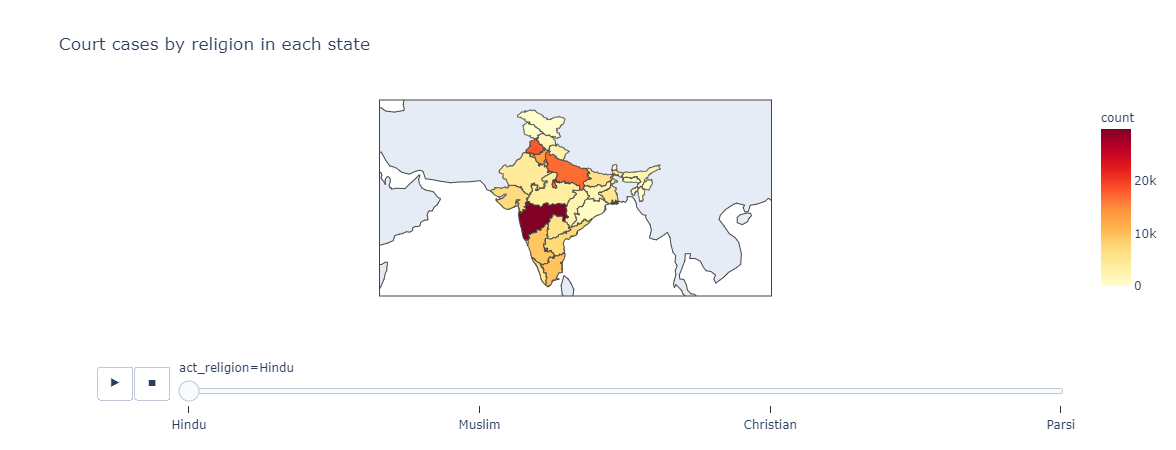

In [232]:
px.choropleth(
    freq_religions_state,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='count',
    animation_frame='act_religion',
    fitbounds="locations",
    color_continuous_scale='YlOrRd',
    title='Court cases by religion in each state'
)

```
NOTE : All these cases give us information about which act the cases uses, so, a sentence that says, "Hindus file more cases" implies "Number of cases filed that use some Hindu-Marriage related act is more than others."
```

# Insights from state/religion-wise choropleth of Marital/Divorce cases
- It is clear that Hindus have the most amount of cases by number.
- Muslims come second at one-tenth of the number of cases filed by Hindus.
- Christians and Parsis have barely any cases.
- Maharashtra is a clear outlier when it comes to such Hindu marriage/divorce cases with almost twice the number of cases than the second highest state, Uttar Pradesh
- Other states have the number of cases in 4 digits, however this is probably directly related to the total amount of Hindu population being higher.
- It is safe to say that Maharashtra, Punjab, Haryana and Uttar Pradesh have significantly more cases than other states.
- These insights might allow a Government/ Research body to closely study at the relationship dynamics of Hindu marriages in these states.
- However, when it comes to Muslim cases, Uttar Pradesh has much more than other states, almost thrice the number of cases compared to the second highest.
- Maharashtra, Karnataka and Kerala have ~500 cases each. Other states are in the double digit range.
- This means that these 4 states have more Muslim marriage cases. However, it is interesting to note that Maharashtra and Uttar Pradesh are the highest ranked in both, Hindu and Muslim cases.
- This also gives insights for the State Governments to conduct studies why this may be the case in Mahrashtra and Uttar Pradesh.
- Most states have no Christian or Parsi cases, this is probably because of lapses in the data collection, however, even now Maharashtra has the most number of Christian cases.

## Generalizing it into a function and plotting necessary plots YoY

In [233]:
df = df.dropna()
df['duration_of_case'] = df.apply(lambda row : (row['date_of_decision'] - row['date_of_filing']).days, axis=1)
df.head()

KeyError: 'date_of_decision'

In [ ]:
duration_religions_state = (df.groupby(['state_name', 'act_religion'])['duration_of_case'].mean())
duration_religions_state = duration_religions_state.to_frame()
duration_religions_state.columns = ['count']
duration_religions_state = duration_religions_state.reset_index()

duration_religions_state.head()

In [ ]:
px.choropleth(
    duration_religions_state,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state_name',
    color='count',
    animation_frame='act_religion',
    fitbounds="locations",
    color_continuous_scale='YlOrRd',
    title='Court cases by religion in each state'
)

In [ ]:
freq_religions_state = None
duration_religions_state = None

In [ ]:
def insight2(df):
    ### Getting statewise and religionwise cases
#     freq_religions_state = (df.groupby(['state_name'])['act_religion'].value_counts())
#     freq_religions_state = freq_religions_state.to_frame()
#     freq_religions_state.columns = ['count']
#     freq_religions_state = freq_religions_state.reset_index()

#     freq_religions_state['state_name'] = freq_religions_state['state_name'].replace(
#                 ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
#                 ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
#             )

#     val = freq_religions_state[freq_religions_state['state_name']=='Jammu & Kashmir'].values

#     for entry in val:
#         freq_religions_state = freq_religions_state.append({
#             'state_name' : 'Ladakh',
#             'act_religion' : entry[1],
#             'count' : entry[2]
#         }, ignore_index=True)
#     freq_religions_state = state_vs_time(df, 'act_religion', ['state_name'], state_religion_freq_list, "value_counts")
#     choropleth_df = clean_state_choropleth(freq_religions_state)
        
#     plot_state_choropleth(choropleth_df, 'count', state_religion_choropleths, 'act_religion')
        
    ### Saving the choropleth obtained
#     fig = px.choropleth(
#         state_religion_choropleths,
#         geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
#         featureidkey='properties.ST_NM',
#         locations='state_name',
#         color='count',
#         animation_frame='act_religion',
#         fitbounds="locations",
#         color_continuous_scale='YlOrRd',
#         title='Court cases by religion in each state'
#     )
    
#     state_religion_choropleths.append(fig)
    
    ### Plotting duration of every case and its distribution
#     df['duration_of_case'] = df.apply(lambda row : (row['date_of_decision'] - row['date_of_filing']).days, axis=1)
#     duration_religions_state = state_vs_time(df, 'duration_of_case', ['state_name', 'act_religion'], dura

#     duration_religions_state = (df.groupby(['state_name', 'act_religion'])['duration_of_case'].mean())
#     duration_religions_state = duration_religions_state.to_frame()
#     duration_religions_state.columns = ['count']
#     duration_religions_state = duration_religions_state.reset_index()

#     duration_religions_state['state_name'] = duration_religions_state['state_name'].replace(
#                 ['Jammu and Kashmir', 'Orissa', 'DNH at Silvasa', 'Diu and Daman'],
#                 ['Jammu & Kashmir', 'Odisha', "Dadra and Nagar Haveli and Daman and Diu", "Dadra and Nagar Haveli and Daman and Diu"]
#             )

#     val = duration_religions_state[duration_religions_state['state_name']=='Jammu & Kashmir'].values

#     for entry in val:
#         duration_religions_state = duration_religions_state.append({
#             'state_name' : 'Ladakh',
#             'act_religion' : entry[1],
#             'count' : entry[2]
#         }, ignore_index=True)
    
    ### Saving the plot
#     fig = px.choropleth(
#         duration_religions_state,
#         geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
#         featureidkey='properties.ST_NM',
#         locations='state_name',
#         color='count',
#         animation_frame='act_religion',
#         fitbounds="locations",
#         color_continuous_scale='YlOrRd',
#         title='Court cases by religion in each state'
#     )
    
#     duration_state_religion_choropleths.append(fig)

# Insight #3
## Checking if there is correlation between child marriage related cases and POCSO cases

In [ ]:
pattern = '.*(Child|CHILD|Children|child).*(Marriage|MARRIAGE|marriage).*'
df_child_marriage = df[df.act_s.str.match(pattern)]
df_child_marriage.head()

> 

In [ ]:
pattern = '.*(POCSO|pocso|posco|Pocso).*'
df_pocso = df[df.act_s.str.match(pattern)]
df_pocso.head()

In [ ]:
def get_type(act_s : str):
    pattern_child_marriage = '.*(Child|CHILD|Children|child).*(Marriage|MARRIAGE|marriage).*'
    pattern_pocso = '.*(POCSO|pocso|posco|Pocso).*'
    
    if bool(re.search(pattern_child_marriage, act_s)):
        return "Child Marriage"
    elif bool(re.search(pattern_pocso, act_s)):
        return "POCSO"
    else:
        return "Unclear"

df2['child_crime_type'] = df.apply(lambda row : get_type(row['act_s']), axis=1)

In [ ]:
df3 = df2[~(df2['act_s']=='Unclear')]
df3.head()

# Pre-classification section

We will try cleaning the data which includes:
- Handling null values
- Feature scaling
- Handling categorical variables

But, before we begin, we must choose our classification problem. 

A few options look interesting:
- Predicting if number of cases that will be filed on a given day in a particular court will be greater than the last day or not.
- Predicting the disposition of given case
- Predicting if the disposition is dismission of the case.

Let us start of with the easier one:
## Predicting if the disposition is dismission of the case
This is an example of **binary classification**

The first thing that is to be done is to use the `disp_name_key.csv` to replace the `disp_name` in every `case_{year}.csv` file.

### Merging case and disposition csv files

In [ ]:
df = preprocessing_case_csv(2014)
df_disp = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "disp_name_key.csv"))

df = df.merge(df_disp, on=['year', 'disp_name'])
df = df.drop(columns='count')
df.head(10)

In [ ]:
df.adv_def_gender.value_counts()

In [ ]:
df_acts_section = pd.read_csv(ACTS_SECTIONS_CSV, usecols=['ddl_case_id', 'act', 'criminal'])

In [ ]:
df = df.merge(df_acts_section, on=['ddl_case_id'])

In [ ]:
df.head(10)

# NEW IDEAS FOR CLASSIFICATION

- Given (first hearing date, most recent hearing date, next hearing date,{othercorrelated stuff}) --> predict if it will reach a decision in the next hearing
- Given ({correlated stuff}) --> predict case disposition
- Check for bias in case disposition w.r.t.:
    - are people in a particular state biased against the defendant?
    - is a particular state biased against females
    - is a judge biased against a certain type of act (favours defendent)

# Classification data
## Preprocessing
- Since we are done with the exploratory data analysis, it is time to figure out a classification problem and go ahead with the predictive analysis section.
- Since, most of our data was 

# Problem
## Checking if the case will be dismissed or not

## Feature Engineering and Data Splits

In [ ]:
def is_dismissed(disp_name : str):
    if disp_name == "dismissed":
        return 1
    else:
        return 0

In [ ]:
def preprocessing_data(year=None, test_mode=False):
    df = preprocessing_case_csv(year, test_mode=test_mode)

    ### Joining disposition names
    df_merge = pd.read_csv(os.path.join(KEYS_CSV_FOLDER, "disp_name_key.csv"),
                          usecols=['year', 'disp_name', 'disp_name_s'])
    df = df.merge(df_merge, on=['year', 'disp_name'])
    
    ### Adding column to indicate 1:Dismissed or 0:Not dismissed
    df['dismission'] = df['disp_name_s'].apply(lambda curr_disp_name : is_dismissed(curr_disp_name))
    
    ### Remmoving entries with disposition not recorded
    df = df[~(df['disp_name_s'] == "disposition var missing")]
    
    ### Adding act, section and criminal data by merging with `df_acts_sections`
    df = df.merge(df_acts_section, on=['ddl_case_id'])
    
    ### Removing unnecessary columns
    df = df.drop(columns=['ddl_case_id', 'year', 'cino', 'disp_name_s', 'court_no','date_of_decision'])
    
    ### Changing dates to duration 
    df = df.dropna()
    df['first_hearing_wait'] = (df['date_first_list'] - df['date_of_filing']).dt.days
    df['curr_hearing_wait'] = (df['date_next_list'] - df['date_last_list']).dt.days
    df['hearing_time_running'] = (df['date_last_list'] - df['date_first_list']).dt.days
    
    ### Conveting to int64
    df['purpose_name'] = df['purpose_name'].astype('int64')
    df['act'] = df['act'].astype('int64')
    df['section'] = df['section'].astype('int64')
    
    ### Removing date columns
    df = df.drop(columns=['date_of_filing', 'date_first_list', 'date_last_list', 'date_next_list'])

    return df

df_test = preprocessing_data(2011)
df_test.head()

## Data split

In [ ]:
def encode_and_data_split(df):
    df = df.dropna()

    ### Encoding other columns
    le = LabelEncoder()
    df['state_code'] = le.fit_transform(df['state_code']) 
    df['dist_code'] = le.fit_transform(df['dist_code'])
    df['judge_position'] = le.fit_transform(df['judge_position']) 
    df['defendant_gender'] = le.fit_transform(df['defendant_gender'])
    df['petitioner_gender'] = le.fit_transform(df['petitioner_gender'])
    df['adv_def_gender'] = le.fit_transform(df['adv_def_gender'])
    df['adv_pet_gender'] = le.fit_transform(df['adv_pet_gender'])
    df['first_hearing_wait'] = le.fit_transform(df['first_hearing_wait']) 
    df['curr_hearing_wait'] = le.fit_transform(df['curr_hearing_wait'])
    df['hearing_time_running'] = le.fit_transform(df['hearing_time_running'])

    ### Splitting with respect to dismissionn
    missing=df[df['dismission'].isnull()]
    fill=df[df['dismission'].notnull()]

    y=fill['dismission']
    print(y.value_counts())
    x=fill.drop(columns = ['dismission', 'disp_name'])

    ### Encode the dismission column
    x=pd.get_dummies(x,drop_first=True)

    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2
                                                   ,random_state=101)

    return x_train,x_test,y_train,y_test

dfcp = df

x_train,x_test,y_train,y_test = encode_and_data_split(dfcp)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Using Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB 

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
def naive_bayes(x_train=None, x_test=None, y_train=None, y_test=None):
    b=BernoulliNB()
    b.fit(x_train,y_train) 

    pred2=b.predict(x_test)
    pred1=b.predict(x_train)
    print(accuracy_score(y_test,pred2))
    print(accuracy_score(y_train,pred1))

    print("\n")

    cm = confusion_matrix(y_test,pred2)
    
    print("Accuracy when actually not dismissed", cm[0][0]/(cm[0][1] + cm[0][0]))
    print("Accuracy when actually dismissed", cm[1][1]/(cm[1][0] + cm[1][1]))
    
    print("\n")

    
#     print(classification_report(y_test,pred2)) #shows all 
    
naive_bayes(x_train,x_test,y_train,y_test)

## Using Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def logistic_regression(x_train=None, x_test=None, y_train=None, y_test=None):
    lr=LogisticRegression()
    lr.fit(x_train,y_train) 

    pred2=lr.predict(x_test)
    pred1=lr.predict(x_train)
    print(accuracy_score(y_test,pred2))
    print(accuracy_score(y_train,pred1))

    print("\n")

    cm = confusion_matrix(y_test,pred2)
    
    print("Accuracy when actually not dismissed", cm[0][0]/(cm[0][1] + cm[0][0]))
    print("Accuracy when actually dismissed", cm[1][1]/(cm[1][0] + cm[1][1]))
    
    print("\n")
    
naive_bayes(x_train,x_test,y_train,y_test)

## Decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def decision_tree(x_train=None, x_test=None, y_train=None, y_test=None):
    d=DecisionTreeClassifier()
    d.fit(x_train,y_train)
    y_pred=d.predict(x_test)

    print(accuracy_score(y_test,y_pred))
    
    print("\n")

    cm = confusion_matrix(y_test,y_pred)
    
    print(cm)
    
    print("Accuracy when actually not dismissed", cm[0][0]/(cm[0][1] + cm[0][0]))
    print("Accuracy when actually dismissed", cm[1][1]/(cm[1][0] + cm[1][1]))
    
    print("\n")
    
decision_tree(x_train, x_test, y_train, y_test)

### Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def random_forest(x_train=None, x_test=None, y_train=None, y_test=None):
    rf=RandomForestClassifier()
    rf.fit(x_train,y_train)
    y_pred=rf.predict(x_test)

    print(accuracy_score(y_test,y_pred))
    
    print("\n")

    cm = confusion_matrix(y_test,y_pred)
    
    print(cm)
    
    print("Accuracy when actually not dismissed", cm[0][0]/(cm[0][1] + cm[0][0]))
    print("Accuracy when actually dismissed", cm[1][1]/(cm[1][0] + cm[1][1]))
    
    print("\n")

random_forest(x_train, x_test, y_train, y_test)

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
def svm(x_train=None, x_test=None, y_train=None, y_test=None):
    svc=SVC()
    svc.fit(x_train,y_train)
    y_pred=svc.predict(x_test)

    print(accuracy_score(y_test,y_pred))
    
    print("\n")

    cm = confusion_matrix(y_test,y_pred)
    
    print(cm)
    
    print("Accuracy when actually not dismissed", cm[0][0]/(cm[0][1] + cm[0][0]))
    print("Accuracy when actually dismissed", cm[1][1]/(cm[1][0] + cm[1][1]))
    
    print("\n")

svm(x_train, x_test, y_train, y_test)

### Labelling dispositions

# Bibliography
- https://stackoverflow.com/questions/50089903/convert-column-to-timestamp-pandas-dataframe
- https://www.geeksforgeeks.org/get-minimum-values-in-rows-or-columns-with-their-index-position-in-pandas-dataframe/
- https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
- https://www.w3schools.com/python/pandas/ref_df_min.asp#:~:text=The%20min()%20method%20returns,minimum%20value%20for%20each%20row.
- https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-by-date/
- https://www.datasciencemadesimple.com/create-frequency-table-of-column-in-pandas-python-2/
- https://datagy.io/pandas-value-counts/
- https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
- https://stackoverflow.com/questions/32888124/pandas-out-of-bounds-nanosecond-timestamp-after-offset-rollforward-plus-adding-a
-  https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
-  https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
-  https://stackoverflow.com/questions/61233041/module-not-found-error-no-module-named-chart-studio
-  https://plotly.com/python/ipython-notebook-tutorial/
- https://stackoverflow.com/questions/68149831/find-if-date-is-weekend-or-weekday-in-pandas-dataframe
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
- https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
- https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
- https://pynative.com/pandas-set-index/
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
- https://stackoverflow.com/questions/62230507/multiple-columns-for-hue-parameter-in-seaborn-violinplot
- https://seaborn.pydata.org/generated/seaborn.violinplot.html
- https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
- https://stackoverflow.com/questions/47002168/correlation-between-two-non-numeric-columns-in-a-pandas-dataframe
- https://stackoverflow.com/questions/48673428/python-pandas-pairwise-frequency-table-with-many-columns
- https://stackoverflow.com/questions/47002168/correlation-between-two-non-numeric-columns-in-a-pandas-dataframe
- https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
- 

# OFFICIAL SUBMISSION AREA END**
